# Multi-Cultivator MC-1000 OD Analysis Workbook

This skript was desinged by Lennart Ole Witting to parse, plot and analyse data from the MC-1000 OD cultivation system for photoautotropic cultivation.
Data is exported by the software OD-View as .csv file. 
First .csv file is read and subsequntly parsed. The parsed data is then plotted and finally growth rate and doubling time are calculated.

Find more information about the cultivation system at: https://photo-bio-reactors.com/products/multi-cultivators/#info

In [1]:
import pandas as pd

# Read raw data from csv

df = pd.read_csv('Example.csv', sep = ',', encoding = 'utf8', header = 0, index_col=False, skiprows= 4)

# Separate OD720 from OD680

df_od720 = df.iloc[:,[3,5,7,9,11,13,15,17]]
df_od720.columns = [1,2,3,4,5,6,7,8]

df_od680 = df.iloc[:,[2,4,6,8,10,12,14,16]]
df_od680.columns = [1,2,3,4,5,6,7,8]

df_time = df.iloc[:,0]/60/60 # Convert time from sec to h

df_temp = df.iloc[:,1] # Grab temperature

Tubes = ['Tube 1', 'Tube 2', 'Tube 3', 'Tube 4', 'Tube 5', 'Tube 6', 'Tube 7', 'Tube 8'] # Specify names of tubes

In [2]:
import pandas as pd

# Check which tubes are in use
    
last_od720 = df_od720.iloc[len(df_od720)-1,:] # extract last line from last_od720

status = []

for od in last_od720:
    if od == 'Overflow':
        status.append(0)
    elif od > 0.005:
        status.append(1)
    else:
        status.append(0) 
        
# status = [1, 1, 1, 1, 1, 1, 1, 1] # In case status in altered manually
        
print(status) # 1 means tube is active, 0 means tube is inactive

[1, 1, 1, 1, 1, 1, 0, 1]


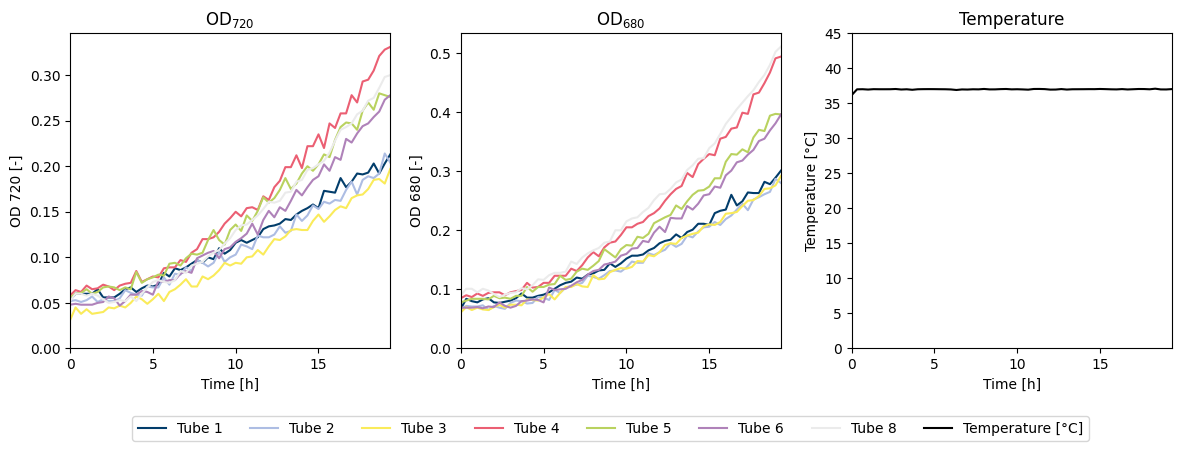

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot the results

corperate_idendity = ['#023d6b', '#adbde3', '#faeb5a', '#eb5f73', '#b9d25f', '#af82b9', '#fab45a', '#ebebeb'] # Fz Juelich corperate identity

fig, ax = plt.subplots(1,3, figsize=(12, 4),facecolor='white')
fig.tight_layout(pad = 2)

for n in range(0,8):
    if status[n] == 1:
        ax[0].plot(df_time,df_od720[n+1], label = Tubes[n] ,color=corperate_idendity[n])
        ax[1].plot(df_time,df_od680[n+1], color=corperate_idendity[n])

ax[2].plot(df_time, df_temp, label='Temperature [°C]', color='k')
    
ax[0].set_xlabel(f'Time [h]')
ax[1].set_xlabel(f'Time [h]')
ax[2].set_xlabel(f'Time [h]')

ax[0].set_xlim(0, df_time.iat[-1])
ax[1].set_xlim(0, df_time.iat[-1])
ax[2].set_xlim(0, df_time.iat[-1])

# find max value in dataframe
ax[0].set_ylim(0, )
ax[1].set_ylim(0, )
ax[2].set_ylim(0, 45)

ax[0].set_ylabel('OD 720 [-]')
ax[1].set_ylabel('OD 680 [-]')
ax[2].set_ylabel('Temperature [°C]')

ax[0].set_title('OD$_{720}$')
ax[1].set_title('OD$_{680}$')
ax[2].set_title('Temperature')

# ax[0].set_yscale('log')

plt.figlegend(loc='lower center', bbox_to_anchor=(0.5, -0.12), ncol=9)

plt.savefig('MC-1000_Plot.png', bbox_inches='tight', transparent=1)

In [4]:
import pandas as pd
import numpy as np

dfs_fitting = []
counter = 0

for n in range(0,8): # Select range within linear measurment for each tube
    if status[n] == 1:
        od720 = df_od720[n+1]
        od720_cutoff = od720[(od720 < 0.4) & (od720 > 0.05)]
        df = pd.concat([df_time, od720_cutoff], axis=1, join='inner')
        df.columns = ['time[s]','OD']
        dfs_fitting.append(df)
        counter = counter + 1

m = []
b = []
doubling_time = []
Tubes_cut = []

for n in range(0, counter): # fit a linear model to  N=m*t+b
    df = dfs_fitting[n]
    m_current, b_current = np.polyfit(df['time[s]'], np.log(df['OD']), 1)
    doubling_time_current = np.log(2) / m_current
    m.append(m_current)
    b.append(b_current)
    doubling_time.append(doubling_time_current)
    Tubes_cut.append(Tubes[n])

df_Results = pd.DataFrame({'Tube': Tubes_cut,
                           'Growth rate [1/h]': m,
                           'Doubling Time [h]': doubling_time}).round(4)

print(df_Results) # Finally print results
df_Results.to_csv(str('Results.csv'),  sep=';', decimal=',')  # Export results to .csv

     Tube  Growth rate [1/h]  Doubling Time [h]
0  Tube 1             0.0748             9.2621
1  Tube 2             0.0776             8.9346
2  Tube 3             0.0862             8.0377
3  Tube 4             0.0948             7.3120
4  Tube 5             0.0892             7.7748
5  Tube 6             0.1006             6.8869
6  Tube 7             0.1003             6.9130


ValueError: x and y must have same first dimension, but have shapes (6,) and (7,)

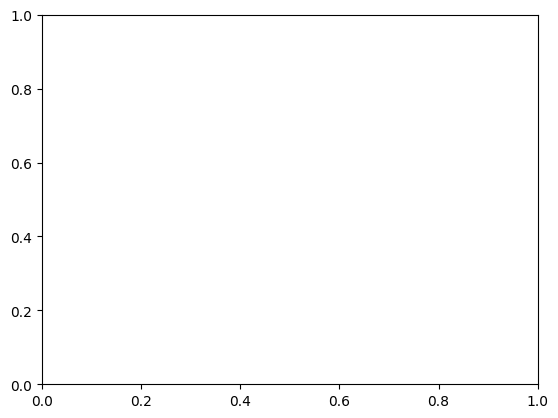

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

# Optional: Create PI_Curve

fig, ax1 = plt.subplots(facecolor='white')
Intensities = pd.DataFrame({'Intensity [µE/(m$^2$$\cdot$s)]': [20, 75, 450, 600, 750, 900]})

ax1.plot(Intensities['Intensity [µE/(m$^2$$\cdot$s)]'], df_Results['Growth rate [1/h]'], lw = 0, marker = 'x')

ax1.set_ylabel('Growth rate 1/h')
ax1.set_xlabel('Intensity [µE/(m$^2$$\cdot$s)]')